## Chaper 8

Before we move onto using ML approaches to recommend items, we need to build a couple of datasets. 

### 8.1 Interactions dataframe with a measure of interest 

We will first create a dataframe with a measure of the interest on a given coupon by a given user. Such measure of interest will be, of course, based on the number of times they have purchased or visited that coupon. 

In [1]:
import numpy as np
import pandas as pd
import os
import argparse
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

from scipy.sparse import lil_matrix, csr_matrix, save_npz

inp_dir = "../datasets/Ponpare/data_processed"
out_dir = "../datasets/Ponpare/data_processed"

As usual

In [2]:
# Interactions
df_purchases_train = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_purchases_train.p'))
df_visits_train = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_visits_train.p'))
df_visits_train.rename(index=str, columns={'view_coupon_id_hash': 'coupon_id_hash'}, inplace=True)

# train users and coupons
df_coupons_train_feat = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_coupons_train_feat.p'))
df_user_train_feat = pd.read_pickle(os.path.join(inp_dir, 'train', 'df_users_train_feat.p'))
train_users = df_user_train_feat.user_id_hash.unique()
train_coupons = df_coupons_train_feat.coupon_id_hash.unique()

# subset activities according to the users and coupons in training
df_vtr = df_visits_train[df_visits_train.user_id_hash.isin(train_users) &
    df_visits_train.coupon_id_hash.isin(train_coupons)]
df_ptr = df_purchases_train[df_purchases_train.user_id_hash.isin(train_users) &
    df_purchases_train.coupon_id_hash.isin(train_coupons)]

Remember from previous notebooks that we lose one customer (22624 $\rightarrow$ 22623) than viewed only one coupon that is not among the training coupons and bought another coupon but not during the training period.

For purchases it will be easy, *"interest"* will be 1.

In [3]:
# for purchases interest will be 1
df_interest_ptr = (df_ptr
    .groupby(['user_id_hash','coupon_id_hash'])['days_to_present']
    .min()
    .reset_index())
df_interest_ptr['interest'] = 1.

df_interest_ptr.head()

,user_id_hash,coupon_id_hash,days_to_present,interest
0,0000b53e182165208887ba65c079fc21,38beeadfe3f97e640367eddae4a8c1b5,274,1.0
1,00035b86e6884589ec8d28fbf2fe7757,25a27d420caa1c46a8d3c0572d27868a,86,1.0
2,0005b1068d5f2b8f2a7c978fcfe1ca06,4a79cd05ecb2bf8672e1d955f5faa7fa,310,1.0
3,0005b1068d5f2b8f2a7c978fcfe1ca06,f0f66195d527a5a9509e139ed367b879,310,1.0
4,000cc06982785a19e2a2fdb40b1c9d59,229ff5cc21c8d26615493be7f3b42841,268,1.0


Because we have already accounted for all those interactions that ended in a purchase, let's remove them from the visits table

In [4]:
# remove from the visits table those pairs user-coupon that ended up in purchases
activity_hash_p = (df_interest_ptr['user_id_hash'] + "_" +
    df_interest_ptr['coupon_id_hash']).unique()
df_vtr['activity_hash'] = (df_vtr['user_id_hash'] + "_" +
    df_vtr['coupon_id_hash'])
df_vtr = df_vtr[~df_vtr.activity_hash.isin(activity_hash_p)]
df_vtr.drop('activity_hash', axis=1, inplace=True)

/home/ubuntu/anaconda3/envs/recotour/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


For visits, *"interest"* will be calculated with some funcion that will depend on number of visits. Let's first calculate the number of visits

In [5]:
# for visits will depend on number of visits
df_vtr_coupon_views = (df_vtr
    .groupby(['user_id_hash','coupon_id_hash'])
    .size()
    .reset_index())
df_vtr_coupon_views.columns = ['user_id_hash','coupon_id_hash','views_count']
df_vtr_most_recent_view = (df_vtr
    .groupby(['user_id_hash','coupon_id_hash'])['days_to_present']
    .min()
    .reset_index())
df_interest_vtr = pd.merge(df_vtr_coupon_views, df_vtr_most_recent_view,
    on=['user_id_hash','coupon_id_hash'])
df_interest_vtr['interest'] = 0.
df_interest_vtr.head()

,user_id_hash,coupon_id_hash,views_count,days_to_present,interest
0,0000b53e182165208887ba65c079fc21,0645faa156f34104e6d8910160868f9f,1,182,0.0
1,0000b53e182165208887ba65c079fc21,18097cd25ab6b7e8eb0481b0e3a3cfd8,1,267,0.0
2,0000b53e182165208887ba65c079fc21,1b581f2ed53f2f2eafbc1560db640194,1,182,0.0
3,0000b53e182165208887ba65c079fc21,1d04e76c44c231d5d05dc1634d20fe8c,2,267,0.0
4,0000b53e182165208887ba65c079fc21,2ab16b8f5aeead6d31dbdb9bd59c41db,2,267,0.0


Now we need to decide which function to use to compute interest based on visits. As has happened a few times already, there is a lot of freedom to do this. Here I will use a sigmoid function and include the code for a "truncated linear" one. Please, feel free to experiment with any other function that you might consider adequate. 

Before moving into visualising the function, let's have a look to the visits distribution

Text(0.5,1,'Views Count Distribution')

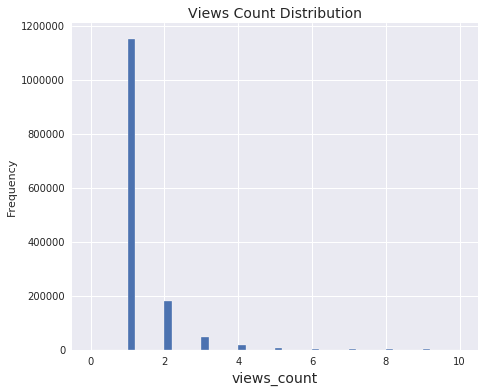

In [6]:
plt.subplot(1, 2, 1)
(df_interest_vtr.views_count).plot.hist(bins=50, figsize=(16, 6), edgecolor = 'white', range = [0, 10])
plt.xlabel('views_count', fontsize=14)
plt.title('Views Count Distribution', fontsize=14)

In [7]:
print("Number of unique views_count values: {}".format(df_interest_vtr.views_count.nunique()))

Number of unique views_count values: 65


In [8]:
#Total number of visits:
print(df_interest_vtr.views_count.sum())
df_interest_vtr.views_count.value_counts()[:10]

1818528


1     1149969
2      180479
3       45541
4       16338
5        7073
6        3409
7        1846
8        1003
9         672
10        435
Name: views_count, dtype: int64

So `1149969/1818528 = 0.63`, 63% of the users that visited coupons visited a given coupon only once. With this information in mind, let's define our two *"interest functions"*. 

When it comes to a sigmoid function, there are three parameters we need to define: 
1. *xmid*: middle point that will defines the change in trend for the S-shaped sigmoid function
2. *tau*: parameter that defines the slope around the middle point
3. *top*: parameter that defines the maximum value as x tends to infinite

For the "truncated linear", which is just a combination of two linear functions, we need to define:
1. *xmid*: point where the change in slope occurs
2. *ylow*: lower y value
3. *ymid*: y value where the change in slope occurs
4. *ytop*: upper y value

Let's visualize how these look

In [9]:
def sigmoid(x, xmid, tau, top):
    """
    Sigmoid with upper limit
    """
    return top / (1. + np.exp(-(x-xmid)/tau))


def combined_linear(x, xmid, ylow, ymid, ytop):
    """
    Truncated straight lines
    """
    m1 = (ymid-ylow)/(xmid)
    b1 = ylow

    x2 = np.max(x)
    m2 = (ytop-ymid)/(x2-xmid)
    b2 = ymid-(m2*xmid)

    x1_range = x[np.where(x<=xmid)[0]]
    x2_range = x[np.where(x>xmid)[0]]

    l1 = m1*x1_range + b1
    l2 = m2*x2_range + b2

    return np.hstack([l1,l2])


def plot_adjustment_func(x, params, xmin=None, xmax=None, func='sigmoid'):

    if not xmin: xmin = np.min(x)
    if not xmax: xmax = np.max(x)
    x = np.sort(x)

    if func == 'sigmoid':
        Z = sigmoid(x, params['xmid'], params['tau'], params['top'])
    elif func == 'linear':
        Z = combined_linear(x, params['xmid'], params['ylow'], params['ymid'], params['ytop'])

    plt.figure(figsize=(10,5))
    plt.plot(x, Z, color='red', lw=1.)
    plt.xlim((xmin, xmax))
    plt.ylabel("views_count")
    plt.ylabel("Interest")
    plt.show()

Let's first have a look to the modified sigmoid

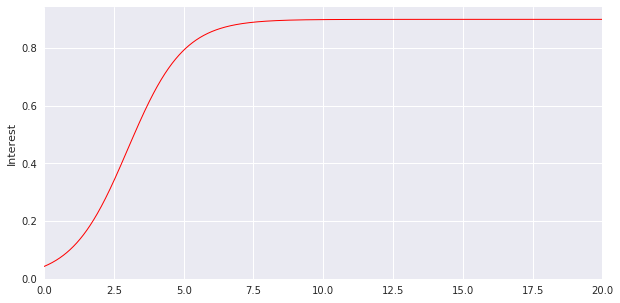

In [10]:
x = np.arange(0, 20, .01)

# This will be the actual parameters I will use
params = {'xmid': 3, 'tau': 1, 'top': 0.9} 
plot_adjustment_func(x, params)

And to the combined or "truncated" linear

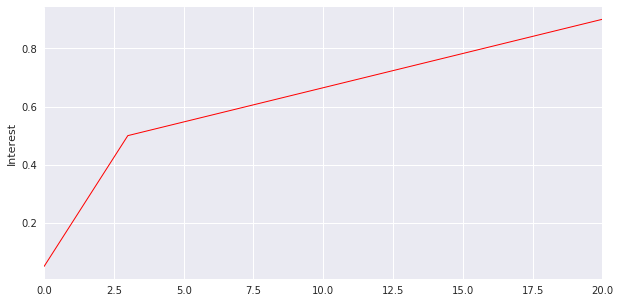

In [11]:
# Let's pick some random parameters
params = {'xmid': 3, 'ylow': 0.05, 'ymid': 0.5, 'ytop': 0.9} 
plot_adjustment_func(x, params, func='linear')

Let's concentrate on the sigmoid function since is the function that I will use throughout the notebooks. For users that only visited a coupon once, their interest in that coupon will be $\sim$0.10 (just run `sigmoid(1., 3, 1, 0.9)`). The the interest increase sharply until we get to $\sim$6 visits (Interest = 0.85). From there in advance, the *interest* metric slowly increases up to 0.9, and will be never be more than that number. Our problem then will consist of trying to predict the interest given a series of user and item features, i.e. a regression. 

Before we move on it is worth to add a caveat. As I showed in the first figure in this notebook, there are 65 different values of `views_count`. 63% of these values are one. Therefore, another option to define or fitting target would be to turn these numbers into categories and face the problem as a multiclass classification. I will leave that to you if you want to explore that set up.

In [12]:
# interest for visits using a sigmoid
vxmid, vtau, vtop = 3, 1, 0.9
df_interest_vtr['interest'] = sigmoid(df_interest_vtr.views_count.values, vxmid, vtau, vtop)
df_interest_vtr.drop('views_count', axis=1, inplace=True)

df_interest_vtr.head()

,user_id_hash,coupon_id_hash,days_to_present,interest
0,0000b53e182165208887ba65c079fc21,0645faa156f34104e6d8910160868f9f,182,0.107283
1,0000b53e182165208887ba65c079fc21,18097cd25ab6b7e8eb0481b0e3a3cfd8,267,0.107283
2,0000b53e182165208887ba65c079fc21,1b581f2ed53f2f2eafbc1560db640194,182,0.107283
3,0000b53e182165208887ba65c079fc21,1d04e76c44c231d5d05dc1634d20fe8c,267,0.242047
4,0000b53e182165208887ba65c079fc21,2ab16b8f5aeead6d31dbdb9bd59c41db,267,0.242047


In addition, a sigmoid function can also be used to compute a *"recency factor"*. 

So far we have treated all coupons as equally important, independently on when they were purchased or visited. A good recommendation algorithm should include, or at least consider, recency. It is likely that the likes of an individual change through time so chances are that your recommendation algorithms work better if they are biased towards more recent interactions. 

Similarly to what we did with the number counts, we can use the sigmoid function above and do:

In [13]:
# in case we want to add a factor depending on recency of purchase
df_interest = pd.concat([df_interest_ptr, df_interest_vtr],
    axis=0, ignore_index=True)
df_interest['days_to_present_inv'] = df_interest.days_to_present.max() - df_interest.days_to_present

rxmid, rtau, rtop = 150, 30, 1
df_interest['recency_factor'] = sigmoid(df_interest.days_to_present_inv.values, rxmid, rtau, rtop)
df_interest.drop(['days_to_present', 'days_to_present_inv'], axis=1, inplace=True)
df_interest = df_interest.sample(frac=1).reset_index(drop=True)

df_interest.head()

,user_id_hash,coupon_id_hash,interest,recency_factor
0,05101ccb6e755c85319a8e73e54eed51,944dc470ee5b84f4d0ea54637ea1f10d,0.107283,0.012128
1,ac98fa7a021c738b5d55be3ea7aa3c70,a0acdade59211f38823e37a125529da6,0.107283,0.854043
2,2d54e581d77a0ef9d492328964339293,10eb8db34b715208d5061f8768e063ab,0.107283,0.954058
3,b3e000518b0b34cf8ba2ddc4a9c5c1fe,0fba2f7bb32be24a7098b98d64795af8,0.242047,0.997975
4,878928bd60c12684dabe9a58415e4c0e,1e0da3283028db0d3ae4a17d777b5206,1.000000,0.985226


Let's save it to disk

In [14]:
df_interest.to_pickle(os.path.join(out_dir,'train','df_interest.p'))

### 8.2 User-Item Interaction Matrix

Once we have the interese dataframe, building an "interaction" or "rating matrix" is straightforward. 

In [15]:
users = df_interest.user_id_hash.unique()
items = df_interest.coupon_id_hash.unique()

# user and item dictionary of indexes 
users_idx_dict = {k:v for v,k in enumerate(users)}
items_idx_dict = {k:v for v,k in enumerate(items)}

In [16]:
# lil_matrix for speed...
interactions_mtx = lil_matrix((users.shape[0], items.shape[0]))
for i, (_,row) in enumerate(df_interest.iterrows()):
    if i%100000==0:
        print('INFO: filled {} out of {} interactions'.format(i, df_interest.shape[0]))
    user_idx = users_idx_dict[row['user_id_hash']]
    item_idx = items_idx_dict[row['coupon_id_hash']]
    interest = row['interest']
    interactions_mtx[user_idx,item_idx] = interest

# ...and csr to save it (save lil format is not implemented)
interactions_mtx = 	interactions_mtx.tocsr()

INFO: filled 0 out of 1560464 interactions
INFO: filled 100000 out of 1560464 interactions
INFO: filled 200000 out of 1560464 interactions
INFO: filled 300000 out of 1560464 interactions
INFO: filled 400000 out of 1560464 interactions
INFO: filled 500000 out of 1560464 interactions
INFO: filled 600000 out of 1560464 interactions
INFO: filled 700000 out of 1560464 interactions
INFO: filled 800000 out of 1560464 interactions
INFO: filled 900000 out of 1560464 interactions
INFO: filled 1000000 out of 1560464 interactions
INFO: filled 1100000 out of 1560464 interactions
INFO: filled 1200000 out of 1560464 interactions
INFO: filled 1300000 out of 1560464 interactions
INFO: filled 1400000 out of 1560464 interactions
INFO: filled 1500000 out of 1560464 interactions


and save

In [17]:
pickle.dump(users_idx_dict, open(os.path.join(out_dir, 'train', 'users_idx_dict.p'), 'wb'))
pickle.dump(items_idx_dict, open(os.path.join(out_dir, 'train', 'items_idx_dict.p'), 'wb'))
save_npz(os.path.join(out_dir, 'train', "interactions_mtx.npz"), interactions_mtx)

### 8.3 User and Coupon features matrices

For convenience, we will build user and coupon features matrices where the row-order is the same as that of the interaction matrix. This is not an absolute requirement, but it will make our life easier in some of the example we go through later. 

In [18]:
# remember we lose one user that did not interact with any of the coupons in the training dataset. 
# Let's make sure all is consistent for upcoming joins:
df_user_train_feat = df_user_train_feat[df_user_train_feat.user_id_hash.isin(users_idx_dict.keys())]

Dataframes with the row/column order for users/items 

In [19]:
df_coupons_order = pd.DataFrame({'coupon_id_hash': list(items_idx_dict.keys()), 'idx': list(items_idx_dict.values())})
df_users_order = pd.DataFrame({'user_id_hash': list(users_idx_dict.keys()), 'idx': list(users_idx_dict.values())})

df_users_order.head()

,user_id_hash,idx
0,05101ccb6e755c85319a8e73e54eed51,0
1,ac98fa7a021c738b5d55be3ea7aa3c70,1
2,2d54e581d77a0ef9d492328964339293,2
3,b3e000518b0b34cf8ba2ddc4a9c5c1fe,3
4,878928bd60c12684dabe9a58415e4c0e,4


Let's enforce that order

In [20]:
df_coupons_train_feat = df_coupons_train_feat.merge(df_coupons_order, on='coupon_id_hash')
df_user_train_feat = df_user_train_feat.merge(df_users_order, on='user_id_hash')

df_user_train_feat.head()

,age,user_id_hash,pref_name_cat,sex_id_cat,catalog_price_mean,catalog_price_median,catalog_price_min,catalog_price_max,discount_price_mean,discount_price_median,...,coupon_id_hash_nunique,item_count_sum,small_area_name_nunique,day_of_week_nunique,median_time_diff,top1_small_area_name_cat,top2_small_area_name_cat,top1_dayofweek_cat,top2_dayofweek_cat,idx
0,25,d9dca3cb44bab12ba313eaa681f663eb,47,0,7200.000000,7200.0,7200.0,7200.0,1575.000000,1575.0,...,1.0,1.0,1.0,1.0,0.0,28,28,2,2,17005
1,34,560574a339f1b25e57b0221e486907ed,2,0,3619.133333,3000.0,320.0,12000.0,1308.666667,1000.0,...,11.0,19.0,4.0,7.0,15.5,4,12,5,3,741
2,41,e66ae91b978b3229f8fd858c80615b73,4,1,2535.000000,2535.0,2535.0,2535.0,1500.000000,1500.0,...,1.0,1.0,1.0,1.0,0.0,6,6,4,4,10199
3,25,43fc18f32eafb05713ec02935e2c2825,47,1,500.750000,1.0,1.0,2000.0,250.000000,0.0,...,4.0,4.0,2.0,3.0,48.0,2,33,0,2,16620
4,62,dc6df8aa860f8db0d710ce9d4839840f,5,1,8426.909091,4500.0,750.0,37800.0,4198.181818,2250.0,...,17.0,36.0,9.0,7.0,5.0,7,15,1,3,4762


In [21]:
df_coupons_train_feat.sort_values('idx', inplace=True)
df_coupons_train_feat.drop(['coupon_id_hash', 'idx'], axis=1, inplace=True)
df_coupons_train_feat = df_coupons_train_feat.astype(int)

df_user_train_feat.sort_values('idx', inplace=True)
df_user_train_feat.drop(['user_id_hash', 'idx'], axis=1, inplace=True)

df_user_train_feat.head()

,age,pref_name_cat,sex_id_cat,catalog_price_mean,catalog_price_median,catalog_price_min,catalog_price_max,discount_price_mean,discount_price_median,discount_price_min,...,purchaseid_hash_count,coupon_id_hash_nunique,item_count_sum,small_area_name_nunique,day_of_week_nunique,median_time_diff,top1_small_area_name_cat,top2_small_area_name_cat,top1_dayofweek_cat,top2_dayofweek_cat
11902,30,26,1,3682.909091,2700.0,500.0,18000.0,1259.242424,1200.0,100.0,...,33.0,32.0,40.0,8.0,7.0,5.0,34,6,1,4
11973,60,2,0,8543.175000,5217.5,450.0,39700.0,2874.500000,1980.0,225.0,...,40.0,40.0,55.0,8.0,7.0,5.0,2,5,1,0
563,17,14,1,5160.000000,3680.0,1800.0,10000.0,2580.000000,1840.0,900.0,...,3.0,3.0,6.0,2.0,2.0,20.5,21,53,3,2
22523,49,5,0,3795.838710,2490.0,1.0,15750.0,1405.806452,980.0,0.0,...,31.0,27.0,40.0,10.0,7.0,4.0,15,7,2,4
21840,37,5,0,4302.307692,3280.0,1.0,17000.0,1787.897436,1490.0,0.0,...,39.0,35.0,56.0,9.0,7.0,4.5,12,4,1,3


We will save the column names for later use and the matrices as csr sparse matrices

In [22]:
user_feat_mtx_colnames = df_user_train_feat.columns.tolist()
item_feat_mtx_colnames = df_coupons_train_feat.columns.tolist()

user_feat_mtx = csr_matrix(df_user_train_feat.values)
item_feat_mtx = csr_matrix(df_coupons_train_feat.values)

And finally, all to disk

In [23]:
pickle.dump(user_feat_mtx_colnames,
    open(os.path.join(out_dir,'train', "user_feat_mtx_colnames.p"), "wb"))
pickle.dump(item_feat_mtx_colnames,
    open(os.path.join(out_dir,'train', "item_feat_mtx_colnames.p"), "wb"))

save_npz(os.path.join(out_dir, 'train', "user_feat_mtx.npz"), user_feat_mtx)
save_npz(os.path.join(out_dir, 'train', "item_feat_mtx.npz"), item_feat_mtx)